# Predicting COVID-19 Infections with LSTM in Romania

> *by Daniel Traian Pele*

Acknowlegments: this notebook is based on the work of Yohan Chung: https://www.kaggle.com/yohancheong/predicting-covid-19-infections-with-lstm.
            
The datatsets are provided by Johns Hopkins University and include the COVID-19 confirmed cases & fatalities for Romania.

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
import os
import random as rn

os.environ['PYTHONHASHSEED'] = '0'

# Setting the seed for numpy-generated random numbers
np.random.seed(37)

# Setting the seed for python random numbers
rn.seed(1254)

# Setting the graph-level random seed.
tf.random.set_seed(89)



# pd.set_option('display.float_format', lambda x: '%.20f' % x)

train_df = pd.read_csv('D:/Python/Covid-19 Forecasting/Romania/JH/train.csv') # historical data
test_df = pd.read_csv('D:/Python/Covid-19 Forecasting/Romania/JH/test.csv') # predictions to be filled

*Cleansing & Transforming Data*


* Filling blank cells with default value
* Removing special char which can malfunction computation
* Converting datetime to day count from the starting date of data
* Scaling data to lower values

In [143]:
train_df = train_df.fillna({'Province_State': 'Unknown'})
test_df = test_df.fillna({'Province_State': 'Unknown'})
train_df['Country_Region']= train_df['Country_Region'].str.replace("'", "")
train_df['Province_State']= train_df['Province_State'].str.replace("'", "")
test_df['Country_Region']= test_df['Country_Region'].str.replace("'", "")
test_df['Province_State']= test_df['Province_State'].str.replace("'", "")
train_df.isna().sum()

Id                0
Province_State    0
Country_Region    0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [144]:
def to_datetime(dt):
    return datetime.datetime.strptime(dt, '%Y-%m-%d')

def count_days(dt):
    return (dt - datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")).days

train_df['Date_dt'] = train_df['Date'].map(to_datetime)
train_df['Day'] = train_df['Date_dt'].map(count_days)
test_df['Date_dt'] = test_df['Date'].map(to_datetime)
test_df['Day'] = test_df['Date_dt'].map(count_days)

In [145]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.utils import to_categorical

# Min-Max Scaler
scaler_c = MinMaxScaler(feature_range=(0, 100))
train_df['ConfirmedCases_scaled'] = None
train_df[['ConfirmedCases_scaled']] = scaler_c.fit_transform(train_df[['ConfirmedCases']])

scaler_f = MinMaxScaler(feature_range=(0, 100))
train_df['Fatalities_scaled'] = None
train_df[['Fatalities_scaled']] = scaler_f.fit_transform(train_df[['Fatalities']])

# Get dummy columns for geo location
geo_columns = []
for i in range(294):
    geo_columns.append('Geo_{}'.format(i))
train_df.drop(columns=geo_columns, inplace=True, errors='ignore')

lbl_encoder = LabelEncoder()
scaler_g = MinMaxScaler(feature_range=(0, 1))
hot_encoder = OneHotEncoder(sparse=False)
train_df['Geo'] = train_df['Country_Region'].astype(str) + '_' + train_df['Province_State'].astype(str)
train_df[['Geo']] = lbl_encoder.fit_transform(train_df[['Geo']])
train_df = pd.get_dummies(train_df, prefix_sep="_", columns=['Geo'])

train_df[['ConfirmedCases', 'ConfirmedCases_scaled', 'Fatalities', 'Fatalities_scaled',  'Geo_0']].head()    

C:\Users\dell\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,ConfirmedCases,ConfirmedCases_scaled,Fatalities,Fatalities_scaled,Geo_0
0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,1


*Preparing Model Input & Target*
The sequential input data with the historical steps of 7, which will be time series to predict the confirmed cases on the next day.

In [146]:
historical_steps = 7
n_output_node = 1

def make_sequential_input(df):
    
    inputs_c, inputs_f, inputs_geo, targets_c, targets_f = [], [], [], [], []
    
    for i in range(len(df) - historical_steps - 1):
        
        if df.iloc[i]['Country_Region'] == df.iloc[i + historical_steps]['Country_Region'] and \
            df.iloc[i]['Province_State'] == df.iloc[i + historical_steps]['Province_State']:
            
            # iloc[a:b] startnig from index 'a' and ending before b
            inputs_c.append(np.array(df.iloc[i : i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # time seires until t-1
            inputs_f.append(np.array(df.iloc[i : i + historical_steps][['Fatalities_scaled']]).tolist()) # time seires until t-1
            inputs_geo.append(np.array(df.iloc[i + historical_steps][geo_columns]).tolist())
            targets_c.append(np.array(df.iloc[i + historical_steps][['ConfirmedCases_scaled']]).tolist()) # result data at time t
            targets_f.append(np.array(df.iloc[i + historical_steps][['Fatalities_scaled']]).tolist()) # result data at time t
              
    return inputs_c, inputs_f, inputs_geo, targets_c, targets_f

# Make sequential input for training and validation
train_inputs, train_inputs_f, train_inputs_geo, train_targets_c, train_targets_f = make_sequential_input(train_df)

print('Train input shape: {}'.format(np.shape(train_inputs)))
print('Train input geo shape: {}'.format(np.shape(train_inputs_geo)))

Train input shape: (21419, 7, 1)
Train input geo shape: (21419, 294)


The validation dataset out of the prepared for modelling.

In [147]:
import random

max_index = np.array(train_inputs).shape[0] - 1
indices = []

for i in range(int(max_index*0.20)):
    indices.append(random.randint(0, max_index))

val_inputs = [ train_inputs[i] for i in indices ]
val_inputs_f = [ train_inputs_f[i] for i in indices ]
val_inputs_geo = [ train_inputs_geo[i] for i in indices  ] 
val_targets_c = [ train_targets_c[i] for i in indices ]
val_targets_f = [ train_targets_f[i] for i in indices ]

train_inputs = [ elem for i, elem in enumerate(train_inputs) if i not in indices ] 
train_inputs_f = [ elem for i, elem in enumerate(train_inputs_f) if i not in indices ] 
train_inputs_geo = [ elem for i, elem in enumerate(train_inputs_geo) if i not in indices ] 
train_targets_c = [ elem for i, elem in enumerate(train_targets_c) if i not in indices ] 
train_targets_f = [ elem for i, elem in enumerate(train_targets_f) if i not in indices ] 

pd.set_option('display.max_colwidth', -1)
print('No. train data: {}'.format(len(train_inputs)))
print('No. validation data: {}'.format(len(val_inputs)))


No. train data: 17551
No. validation data: 4283


C:\Users\dell\anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# LSTM with Initial State
MSLE - Mean squared log error which give more penalty on underestimation over overestimation, since the trend is likely to grow up.

The following codes were used when creating LSTM model with time series data for confirmed cases,
as well as geo location.

Epoch 1/200
275/275 [==============================] - 2s 7ms/step - loss: 0.0378 - mean_absolute_error: 0.4141 - mean_squared_error: 16.3543 - val_loss: 0.0166 - val_mean_absolute_error: 0.3048 - val_mean_squared_error: 13.2315
Epoch 2/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0155 - mean_absolute_error: 0.3250 - mean_squared_error: 13.3008 - val_loss: 0.0116 - val_mean_absolute_error: 0.2785 - val_mean_squared_error: 11.6960
Epoch 3/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.2934 - mean_squared_error: 11.7069 - val_loss: 0.0088 - val_mean_absolute_error: 0.2466 - val_mean_squared_error: 10.5206
Epoch 4/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0088 - mean_absolute_error: 0.2707 - mean_squared_error: 10.5480 - val_loss: 0.0072 - val_mean_absolute_error: 0.2320 - val_mean_squared_error: 9.5473
Epoch 5/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0071 - m

275/275 [==============================] - 2s 6ms/step - loss: 4.6936e-04 - mean_absolute_error: 0.0651 - mean_squared_error: 0.9068 - val_loss: 6.1139e-04 - val_mean_absolute_error: 0.0668 - val_mean_squared_error: 0.7987
Epoch 37/200
275/275 [==============================] - 2s 6ms/step - loss: 4.6583e-04 - mean_absolute_error: 0.0629 - mean_squared_error: 0.8504 - val_loss: 4.4656e-04 - val_mean_absolute_error: 0.0513 - val_mean_squared_error: 0.6711
Epoch 38/200
275/275 [==============================] - 2s 6ms/step - loss: 4.2454e-04 - mean_absolute_error: 0.0597 - mean_squared_error: 0.8221 - val_loss: 3.6910e-04 - val_mean_absolute_error: 0.0441 - val_mean_squared_error: 0.6006
Epoch 39/200
275/275 [==============================] - 2s 6ms/step - loss: 4.0580e-04 - mean_absolute_error: 0.0557 - mean_squared_error: 0.6888 - val_loss: 3.8643e-04 - val_mean_absolute_error: 0.0460 - val_mean_squared_error: 0.5558
Epoch 40/200
275/275 [==============================] - 2s 6ms/step -

Epoch 71/200
275/275 [==============================] - 2s 6ms/step - loss: 2.6922e-04 - mean_absolute_error: 0.0384 - mean_squared_error: 0.1476 - val_loss: 3.9612e-04 - val_mean_absolute_error: 0.0416 - val_mean_squared_error: 0.1548
Epoch 72/200
275/275 [==============================] - 2s 6ms/step - loss: 3.0959e-04 - mean_absolute_error: 0.0405 - mean_squared_error: 0.1902 - val_loss: 3.1216e-04 - val_mean_absolute_error: 0.0280 - val_mean_squared_error: 0.1047
Epoch 73/200
275/275 [==============================] - 2s 6ms/step - loss: 2.8097e-04 - mean_absolute_error: 0.0391 - mean_squared_error: 0.1716 - val_loss: 2.3934e-04 - val_mean_absolute_error: 0.0231 - val_mean_squared_error: 0.0975
Epoch 74/200
275/275 [==============================] - 2s 6ms/step - loss: 2.6603e-04 - mean_absolute_error: 0.0372 - mean_squared_error: 0.1525 - val_loss: 2.9106e-04 - val_mean_absolute_error: 0.0275 - val_mean_squared_error: 0.1022
Epoch 75/200
275/275 [==============================] - 

Epoch 106/200
275/275 [==============================] - 2s 6ms/step - loss: 2.4121e-04 - mean_absolute_error: 0.0346 - mean_squared_error: 0.0964 - val_loss: 2.4564e-04 - val_mean_absolute_error: 0.0248 - val_mean_squared_error: 0.0709
Epoch 107/200
275/275 [==============================] - 2s 6ms/step - loss: 2.5256e-04 - mean_absolute_error: 0.0339 - mean_squared_error: 0.0889 - val_loss: 2.3742e-04 - val_mean_absolute_error: 0.0260 - val_mean_squared_error: 0.0746
Epoch 108/200
275/275 [==============================] - 2s 6ms/step - loss: 2.6394e-04 - mean_absolute_error: 0.0377 - mean_squared_error: 0.1185 - val_loss: 2.4343e-04 - val_mean_absolute_error: 0.0246 - val_mean_squared_error: 0.0622
Epoch 109/200
275/275 [==============================] - 2s 6ms/step - loss: 2.6224e-04 - mean_absolute_error: 0.0362 - mean_squared_error: 0.1161 - val_loss: 2.5569e-04 - val_mean_absolute_error: 0.0248 - val_mean_squared_error: 0.0578
Epoch 110/200
275/275 [=============================

275/275 [==============================] - 1s 5ms/step - loss: 2.3951e-04 - mean_absolute_error: 0.0338 - mean_squared_error: 0.0973 - val_loss: 2.6749e-04 - val_mean_absolute_error: 0.0298 - val_mean_squared_error: 0.0827
Epoch 141/200
275/275 [==============================] - 2s 5ms/step - loss: 2.3974e-04 - mean_absolute_error: 0.0337 - mean_squared_error: 0.0915 - val_loss: 2.9616e-04 - val_mean_absolute_error: 0.0223 - val_mean_squared_error: 0.0411
Epoch 142/200
275/275 [==============================] - 1s 5ms/step - loss: 2.3088e-04 - mean_absolute_error: 0.0323 - mean_squared_error: 0.0808 - val_loss: 2.2681e-04 - val_mean_absolute_error: 0.0194 - val_mean_squared_error: 0.0434
Epoch 143/200
275/275 [==============================] - 2s 6ms/step - loss: 2.4969e-04 - mean_absolute_error: 0.0356 - mean_squared_error: 0.1039 - val_loss: 2.3735e-04 - val_mean_absolute_error: 0.0253 - val_mean_squared_error: 0.0677
Epoch 144/200
275/275 [==============================] - 2s 6ms/st

Epoch 175/200
275/275 [==============================] - 2s 6ms/step - loss: 2.3087e-04 - mean_absolute_error: 0.0331 - mean_squared_error: 0.0891 - val_loss: 2.5459e-04 - val_mean_absolute_error: 0.0274 - val_mean_squared_error: 0.0535
Epoch 176/200
275/275 [==============================] - 2s 6ms/step - loss: 2.2775e-04 - mean_absolute_error: 0.0337 - mean_squared_error: 0.0870 - val_loss: 2.4148e-04 - val_mean_absolute_error: 0.0260 - val_mean_squared_error: 0.0528
Epoch 177/200
275/275 [==============================] - 2s 6ms/step - loss: 2.3121e-04 - mean_absolute_error: 0.0340 - mean_squared_error: 0.1000 - val_loss: 2.4217e-04 - val_mean_absolute_error: 0.0208 - val_mean_squared_error: 0.0367
Epoch 178/200
275/275 [==============================] - 2s 5ms/step - loss: 2.2751e-04 - mean_absolute_error: 0.0313 - mean_squared_error: 0.0775 - val_loss: 2.6261e-04 - val_mean_absolute_error: 0.0270 - val_mean_squared_error: 0.0489
Epoch 179/200
275/275 [=============================

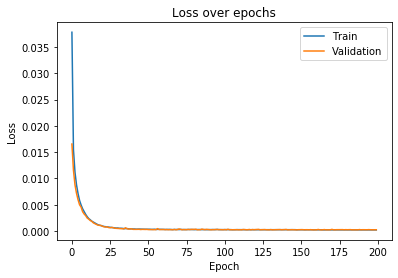

Epoch 1/200
275/275 [==============================] - 2s 7ms/step - loss: 0.0180 - mean_absolute_error: 0.1693 - mean_squared_error: 6.4436 - val_loss: 0.0070 - val_mean_absolute_error: 0.1190 - val_mean_squared_error: 4.5314
Epoch 2/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0069 - mean_absolute_error: 0.1356 - mean_squared_error: 5.2410 - val_loss: 0.0048 - val_mean_absolute_error: 0.1030 - val_mean_squared_error: 4.0611
Epoch 3/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0050 - mean_absolute_error: 0.1203 - mean_squared_error: 4.7418 - val_loss: 0.0038 - val_mean_absolute_error: 0.0933 - val_mean_squared_error: 3.7374
Epoch 4/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0039 - mean_absolute_error: 0.1083 - mean_squared_error: 4.3706 - val_loss: 0.0032 - val_mean_absolute_error: 0.0895 - val_mean_squared_error: 3.4826
Epoch 5/200
275/275 [==============================] - 2s 6ms/step - loss: 0.0033 - mean_abs

275/275 [==============================] - 2s 6ms/step - loss: 3.0095e-04 - mean_absolute_error: 0.0355 - mean_squared_error: 0.7584 - val_loss: 2.3889e-04 - val_mean_absolute_error: 0.0253 - val_mean_squared_error: 0.4106
Epoch 37/200
275/275 [==============================] - 2s 6ms/step - loss: 3.0434e-04 - mean_absolute_error: 0.0362 - mean_squared_error: 0.6849 - val_loss: 2.1058e-04 - val_mean_absolute_error: 0.0225 - val_mean_squared_error: 0.3823
Epoch 38/200
275/275 [==============================] - 2s 6ms/step - loss: 2.8131e-04 - mean_absolute_error: 0.0344 - mean_squared_error: 0.6794 - val_loss: 2.0866e-04 - val_mean_absolute_error: 0.0217 - val_mean_squared_error: 0.3552
Epoch 39/200
275/275 [==============================] - 2s 6ms/step - loss: 2.5197e-04 - mean_absolute_error: 0.0312 - mean_squared_error: 0.6049 - val_loss: 1.8576e-04 - val_mean_absolute_error: 0.0200 - val_mean_squared_error: 0.3239
Epoch 40/200
275/275 [==============================] - 2s 5ms/step -

Epoch 71/200
275/275 [==============================] - 2s 6ms/step - loss: 1.3133e-04 - mean_absolute_error: 0.0198 - mean_squared_error: 0.1375 - val_loss: 1.3567e-04 - val_mean_absolute_error: 0.0109 - val_mean_squared_error: 0.0364
Epoch 72/200
275/275 [==============================] - 2s 6ms/step - loss: 1.5372e-04 - mean_absolute_error: 0.0194 - mean_squared_error: 0.1371 - val_loss: 1.9195e-04 - val_mean_absolute_error: 0.0164 - val_mean_squared_error: 0.0503
Epoch 73/200
275/275 [==============================] - 2s 6ms/step - loss: 1.3813e-04 - mean_absolute_error: 0.0189 - mean_squared_error: 0.1005 - val_loss: 1.4938e-04 - val_mean_absolute_error: 0.0136 - val_mean_squared_error: 0.0380
Epoch 74/200
275/275 [==============================] - 2s 6ms/step - loss: 1.2824e-04 - mean_absolute_error: 0.0180 - mean_squared_error: 0.1028 - val_loss: 1.3568e-04 - val_mean_absolute_error: 0.0126 - val_mean_squared_error: 0.0350
Epoch 75/200
275/275 [==============================] - 

Epoch 106/200
275/275 [==============================] - 2s 6ms/step - loss: 1.2633e-04 - mean_absolute_error: 0.0168 - mean_squared_error: 0.0557 - val_loss: 1.3679e-04 - val_mean_absolute_error: 0.0101 - val_mean_squared_error: 0.0167
Epoch 107/200
275/275 [==============================] - 2s 6ms/step - loss: 1.2018e-04 - mean_absolute_error: 0.0165 - mean_squared_error: 0.0532 - val_loss: 1.2395e-04 - val_mean_absolute_error: 0.0099 - val_mean_squared_error: 0.0142
Epoch 108/200
275/275 [==============================] - 2s 6ms/step - loss: 1.2275e-04 - mean_absolute_error: 0.0164 - mean_squared_error: 0.0700 - val_loss: 1.2611e-04 - val_mean_absolute_error: 0.0110 - val_mean_squared_error: 0.0131
Epoch 109/200
275/275 [==============================] - 2s 6ms/step - loss: 1.2161e-04 - mean_absolute_error: 0.0157 - mean_squared_error: 0.0518 - val_loss: 1.2193e-04 - val_mean_absolute_error: 0.0115 - val_mean_squared_error: 0.0224
Epoch 110/200
275/275 [=============================

275/275 [==============================] - 2s 6ms/step - loss: 1.1680e-04 - mean_absolute_error: 0.0158 - mean_squared_error: 0.0496 - val_loss: 1.2709e-04 - val_mean_absolute_error: 0.0100 - val_mean_squared_error: 0.0138
Epoch 141/200
275/275 [==============================] - 2s 6ms/step - loss: 1.1398e-04 - mean_absolute_error: 0.0155 - mean_squared_error: 0.0481 - val_loss: 1.4573e-04 - val_mean_absolute_error: 0.0110 - val_mean_squared_error: 0.0146
Epoch 142/200
275/275 [==============================] - 2s 5ms/step - loss: 1.0656e-04 - mean_absolute_error: 0.0145 - mean_squared_error: 0.0390 - val_loss: 1.1834e-04 - val_mean_absolute_error: 0.0083 - val_mean_squared_error: 0.0096
Epoch 143/200
275/275 [==============================] - 2s 6ms/step - loss: 1.0728e-04 - mean_absolute_error: 0.0147 - mean_squared_error: 0.0434 - val_loss: 1.3101e-04 - val_mean_absolute_error: 0.0105 - val_mean_squared_error: 0.0162
Epoch 144/200
275/275 [==============================] - 2s 6ms/st

Epoch 175/200
275/275 [==============================] - 2s 6ms/step - loss: 1.0369e-04 - mean_absolute_error: 0.0143 - mean_squared_error: 0.0357 - val_loss: 1.2578e-04 - val_mean_absolute_error: 0.0080 - val_mean_squared_error: 0.0079
Epoch 176/200
275/275 [==============================] - 2s 6ms/step - loss: 9.2229e-05 - mean_absolute_error: 0.0135 - mean_squared_error: 0.0312 - val_loss: 1.3421e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 0.0093
Epoch 177/200
275/275 [==============================] - 2s 6ms/step - loss: 1.0670e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 0.0589 - val_loss: 1.2231e-04 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 0.0113
Epoch 178/200
275/275 [==============================] - 2s 6ms/step - loss: 1.1967e-04 - mean_absolute_error: 0.0157 - mean_squared_error: 0.0397 - val_loss: 1.8491e-04 - val_mean_absolute_error: 0.0125 - val_mean_squared_error: 0.0081
Epoch 179/200
275/275 [=============================

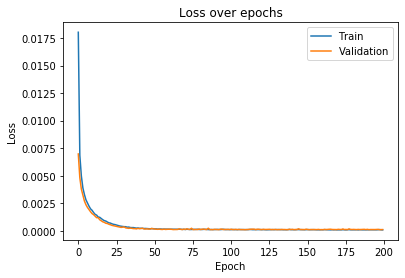

INFO:tensorflow:Assets written to: model_c_with_state\assets
INFO:tensorflow:Assets written to: model_f_with_state\assets


In [148]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

n_output_node = 1
input_shape=np.array(train_inputs).shape[-2:]
input_shape_geo=np.array(train_inputs_geo).shape

batch_size = 64
epochs = 200
lr = 0.001


def create_model(inputs, inputs_geo, targets, v_inputs, v_inputs_geo, v_targets):
    
    geo_input = Input(shape=(294,), name='input_geo')
    h_state = Dense(64, activation='relu')(geo_input)
    h_state = Dense(64, activation='relu')(h_state)
    c_state = Dense(64, activation='relu')(geo_input)
    c_state = Dense(64, activation='relu')(c_state)

    ts_input = Input(shape=input_shape, name='input_ts')
    lstm = LSTM(64, return_sequences=True)(ts_input, initial_state=[ h_state, c_state ])
    lstm = Dropout(0.05)(lstm)
    lstm = LSTM(32)(lstm)
    lstm = Dropout(0.05)(lstm)
    main_output = Dense(n_output_node, activation='relu', name='output_main')(lstm)
    
    model = Model(inputs=[ geo_input, ts_input ], outputs=main_output)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), \
                  loss=tf.keras.losses.MSLE, metrics=[ tf.keras.metrics.MeanAbsoluteError(),
                                                      tf.keras.metrics.MeanSquaredError() ])
    
    history = model.fit([ inputs_geo, inputs ],  targets, \
              epochs=epochs, \
              batch_size=batch_size, \
              validation_data=({ 'input_geo': v_inputs_geo, 'input_ts': v_inputs },{ 'output_main': v_targets}))

    scores = model.evaluate({ 'input_geo': inputs_geo, 'input_ts': inputs }, targets)
    print("Model Accuracy: {}".format(scores))

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
    return model
                        
    

model_cases = create_model(np.array(train_inputs), np.array(train_inputs_geo), np.array(train_targets_c), np.array(val_inputs), np.array(val_inputs_geo), np.array(val_targets_c))
model_fatality = create_model(np.array(train_inputs_f), np.array(train_inputs_geo), np.array(train_targets_f), np.array(val_inputs_f), np.array(val_inputs_geo), np.array(val_targets_f))

model_cases.save('model_c_with_state')
model_fatality.save('model_f_with_state')

# Interpreting Data

In [149]:
model_cases = tf.keras.models.load_model('model_c_with_state')
model_fatality = tf.keras.models.load_model('model_f_with_state')

In [150]:
def predict_cases(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['ConfirmedCases_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['ConfirmedCases']])
    
    predictions = model_cases.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['ConfirmedCases']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_c.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
    
def predict_fatality(country, state):
    
    df = train_df[(train_df['Country_Region'] == country) & (train_df['Province_State'] == state) ]

    inputs = np.array(df[['Fatalities_scaled']][-historical_steps-1:-1])
    inputs_geo = np.array(df.iloc[-1][geo_columns])
    actuals = np.array(df.iloc[-1][['Fatalities']])
    
    predictions = model_fatality.predict([  np.array(inputs_geo).astype(np.float32).reshape(1, len(geo_columns)), np.array(inputs).reshape(1, input_shape[0], input_shape[1]) ]).reshape(-1).tolist()
    
    print('Inputs: {}, Pred: {}, Expected: {}'.format( \
        np.array(df[['Fatalities']][-historical_steps-1:-1])[:,0].tolist(), \
        scaler_f.inverse_transform(np.array(predictions).reshape(-1,1)), \
        actuals))
      

predict_cases('Romania', 'Unknown')


predict_fatality('Romania', 'Unknown')


Inputs: [2245.0, 2460.0, 2738.0, 3183.0, 3613.0, 3864.0, 4057.0], Pred: [[4502.9290869]], Expected: [4417.0]
Inputs: [82.0, 92.0, 115.0, 133.0, 146.0, 151.0, 176.0], Pred: [[198.84592189]], Expected: [197.0]


In [151]:
import time

test_df['ConfirmedCases'] = None
test_df['Fatalities'] = None
geo_df = None

tic = time.perf_counter()
temp_df = train_df

# For each test row
for i in range(len(test_df)):
    
    if i%1000 == 0:
        toc = time.perf_counter()
        print('Looping throught the index {} - {:.2f} sec(s) taken...'.format(i, (toc-tic)))
   
    current = test_df.iloc[i]         
    geo_df = temp_df[(temp_df.Country_Region == current.Country_Region) & (temp_df.Province_State == current.Province_State) & (temp_df.Day >= (current.Day - historical_steps)) & (temp_df.Day <= (current.Day))]
        
     # Find historical steps in train data
    if not geo_df.empty and geo_df.shape[0] >=historical_steps:                 
        
        
        if geo_df.shape[0] == 8:
            input_geo = np.array(geo_df.iloc[-historical_steps-1][geo_columns]).astype(np.float32).reshape(1, len(geo_columns))
            pred = model_cases.predict([ input_geo, np.array(geo_df.iloc[-historical_steps-1:-1][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
            pred_f = model_fatality.predict([ input_geo, np.array(geo_df.iloc[-historical_steps-1:-1,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
        else:
            input_geo = np.array(geo_df.iloc[-historical_steps][geo_columns]).astype(np.float32).reshape(1, len(geo_columns))
            pred = model_cases.predict([ input_geo, np.array(geo_df.iloc[-historical_steps:,][['ConfirmedCases_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
            pred_f = model_fatality.predict([ input_geo, np.array(geo_df.iloc[-historical_steps:,][['Fatalities_scaled']]).reshape(1, input_shape[0], input_shape[1]) ])
              
        test_df.loc[i, 'ConfirmedCases_scaled'] = pred[0][0]
        test_df.loc[i, 'Fatalities_scaled'] = pred_f[0][0]
        
        # Save current data in train_df for next if empty
        if geo_df.iloc[-1:,].Day.values[0] != current.Day:  
            
            new_item = { 'ConfirmedCases_scaled': pred[0][0], 'Fatalities_scaled': pred_f[0][0], 'Day': current.Day, \
                         'Country_Region': current.Country_Region, 'Province_State': current.Province_State }
            
            for j in range(len(geo_columns)):
                new_item['Geo_' + str(j)] = 1 if geo_df.iloc[-1:,]['Geo_' + str(j)].values[0] == 1 else 0
            
            temp_df = temp_df.append(new_item, ignore_index=True)

test_df[['ConfirmedCases']] = scaler_c.inverse_transform(test_df[['ConfirmedCases_scaled']])
test_df[['Fatalities']] = scaler_f.inverse_transform(test_df[['Fatalities_scaled']]) 

Looping throught the index 0 - 0.01 sec(s) taken...
Looping throught the index 1000 - 203.64 sec(s) taken...
Looping throught the index 2000 - 415.50 sec(s) taken...
Looping throught the index 3000 - 633.88 sec(s) taken...
Looping throught the index 4000 - 857.33 sec(s) taken...
Looping throught the index 5000 - 1084.29 sec(s) taken...
Looping throught the index 6000 - 1315.19 sec(s) taken...
Looping throught the index 7000 - 1561.43 sec(s) taken...
Looping throught the index 8000 - 1809.19 sec(s) taken...
Looping throught the index 9000 - 2080.31 sec(s) taken...
Looping throught the index 10000 - 2320.52 sec(s) taken...
Looping throught the index 11000 - 2560.16 sec(s) taken...
Looping throught the index 12000 - 2798.86 sec(s) taken...
Looping throught the index 13000 - 3038.78 sec(s) taken...


In [152]:
test_df[(test_df.Country_Region=='Romania') & (test_df.Province_State=='Unknown')].iloc[-35:,:]


,ForecastId,Province_State,Country_Region,Date,Date_dt,Day,ConfirmedCases,Fatalities,ConfirmedCases_scaled,Fatalities_scaled
8608,8609,Unknown,Romania,2020-04-03,2020-04-03,72,3086.269547,133.853556,2.174317,0.781535
8609,8610,Unknown,Romania,2020-04-04,2020-04-04,73,3539.692635,155.744218,2.493760,0.909349
8610,8611,Unknown,Romania,2020-04-05,2020-04-05,74,3969.848940,169.303937,2.796811,0.988521
8611,8612,Unknown,Romania,2020-04-06,2020-04-06,75,4264.887202,175.240693,3.004669,1.023184
8612,8613,Unknown,Romania,2020-04-07,2020-04-07,76,4502.929087,198.845922,3.172373,1.161008
8613,8614,Unknown,Romania,2020-04-08,2020-04-08,77,4851.755543,222.731353,3.418125,1.300469
8614,8615,Unknown,Romania,2020-04-09,2020-04-09,78,5265.857726,245.172671,3.709866,1.431498
8615,8616,Unknown,Romania,2020-04-10,2020-04-10,79,5672.841665,268.501474,3.996591,1.567709
8616,8617,Unknown,Romania,2020-04-11,2020-04-11,80,6072.469453,292.565983,4.278134,1.708215
8617,8618,Unknown,Romania,2020-04-12,2020-04-12,81,6480.513312,316.754626,4.565607,1.849446


In [153]:
def plot_by_country(country, state):

  
    hist_df = train_df[(train_df.Country_Region == country) & (train_df.Province_State == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'sum'}).reset_index()
    pred_df = test_df[(test_df.Country_Region == country) & (test_df.Province_State == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'ConfirmedCases': 'sum'}).reset_index()
    print(pred_df)
    pred_df['Date']=pd.to_datetime(pred_df['Date'])  
    hist_df['Date']=pd.to_datetime(hist_df['Date'])  
    pred_df.set_index('Date',inplace=True)
    hist_df.set_index('Date',inplace=True)
    plt.title('Romania Confirmed Cases')
    plt.plot(hist_df.ConfirmedCases, label='Historical',color='blue')
    plt.plot(pred_df.ConfirmedCases, label='Predictive',color='red',linestyle='--')
    #plt.axvline(x='2020-03-16', color='r', linestyle='--', linewidth=1, label='State of Emergency')
    plt.xlabel('Day',fontsize=10)
    plt.ylabel('Confirmed Cases',fontsize=10)
    plt.xticks(rotation=90,fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()
    plt.show()
    
    hist_df = train_df[(train_df.Country_Region == country) & (train_df.Province_State \
         == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'Fatalities': 'sum'}).reset_index()
    pred_df = test_df[(test_df.Country_Region == country) & (test_df.Province_State \
        == state)].groupby(['Country_Region', 'Province_State', 'Day', 'Date']).agg({'Fatalities': 'sum'}).reset_index()
    print(pred_df)
    pred_df['Date']=pd.to_datetime(pred_df['Date'])  
    hist_df['Date']=pd.to_datetime(hist_df['Date'])  
    pred_df.set_index('Date',inplace=True)
    hist_df.set_index('Date',inplace=True)
    plt.title('Romania Deaths')
    plt.plot(hist_df.Fatalities, label='Historical',color='blue')
    plt.plot(pred_df.Fatalities, label='Predictive',color='red',linestyle='--')
    #plt.axvline(x='2020-03-16', color='r', linestyle='--', linewidth=1, label='State of Emergency')
    plt.xlabel('Day',fontsize=10)
    plt.ylabel('Deaths',fontsize=10)
    plt.xticks(rotation=90,fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend()
    plt.show()
    

   Country_Region Province_State  Day        Date  ConfirmedCases
0   Romania        Unknown        64   2020-03-26  1068.412030   
1   Romania        Unknown        65   2020-03-27  1201.911428   
2   Romania        Unknown        66   2020-03-28  1487.524717   
3   Romania        Unknown        67   2020-03-29  1676.628926   
4   Romania        Unknown        68   2020-03-30  2075.556701   
5   Romania        Unknown        69   2020-03-31  2395.772783   
6   Romania        Unknown        70   2020-04-01  2579.283650   
7   Romania        Unknown        71   2020-04-02  2809.866336   
8   Romania        Unknown        72   2020-04-03  3086.269547   
9   Romania        Unknown        73   2020-04-04  3539.692635   
10  Romania        Unknown        74   2020-04-05  3969.848940   
11  Romania        Unknown        75   2020-04-06  4264.887202   
12  Romania        Unknown        76   2020-04-07  4502.929087   
13  Romania        Unknown        77   2020-04-08  4851.755543   
14  Romani

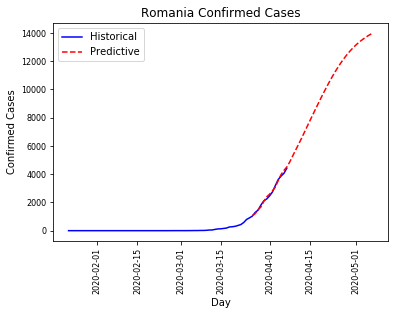

   Country_Region Province_State  Day        Date   Fatalities
0   Romania        Unknown        64   2020-03-26  20.746921  
1   Romania        Unknown        65   2020-03-27  28.432531  
2   Romania        Unknown        66   2020-03-28  32.805541  
3   Romania        Unknown        67   2020-03-29  45.027765  
4   Romania        Unknown        68   2020-03-30  53.518414  
5   Romania        Unknown        69   2020-03-31  77.174114  
6   Romania        Unknown        70   2020-04-01  98.417017  
7   Romania        Unknown        71   2020-04-02  110.291111 
8   Romania        Unknown        72   2020-04-03  133.853556 
9   Romania        Unknown        73   2020-04-04  155.744218 
10  Romania        Unknown        74   2020-04-05  169.303937 
11  Romania        Unknown        75   2020-04-06  175.240693 
12  Romania        Unknown        76   2020-04-07  198.845922 
13  Romania        Unknown        77   2020-04-08  222.731353 
14  Romania        Unknown        78   2020-04-09  245.

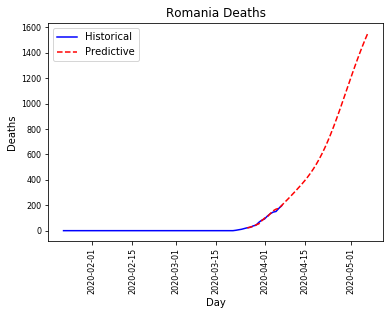

[None]

In [154]:
[ plot_by_country(country, state) for country, state in [ \
    ('Romania',  'Unknown')]]

In [155]:
test_df[['ForecastId', \
         'ConfirmedCases', 'Fatalities']].to_csv('D:/Python/Covid-19 Forecasting/Romania/JH/prediction.csv',\
                                                  index=False)